In [1]:
__nbid__ = '0053'
__author__ = 'Eric Armengaud, Benjamin Weaver <benjamin.weaver@noirlab.edu>, Alice Jacques <alice.jacques@noirlab.edu>'
__version__ = '20251215' # yyyymmdd
__datasets__ = ['boss_dr17', 'desi_dr1', 'sdss_dr17']
__keywords__ = ['sparcl', 'spectroscopy', 'sdss spectra', 'desi spectra', 'tutorial', 'prospect', 'specutils']

# Obtain and plot spectra data using SPARCL, prospect, and specutils

*Credit*: [Eric Armengaud](https://github.com/armengau), Saclay - CEA, is the primary author of prospect. See also the [prospect contributors](https://github.com/desihub/prospect/graphs/contributors). [Benjamin Weaver](https://github.com/weaverba137) and [Alice Jacques](https://github.com/jacquesalice) contributed to the development of this notebook.

### Table of contents
* [Summary & goals](#goals)
* [Disclaimer & attribution](#disclaimer)
* [Imports & setup](#imports)
* Find, retrieve, and plot spectra from:
    * [DESI](#desi)
    * [SDSS](#sdss)
    * [(e)BOSS](#boss)

<a class="anchor" id="goals"></a>
## Summary & goals

[prospect](https://github.com/desihub/prospect/) is an interactive spectrum visualization tool created by the [DESI collaboration](https://www.desi.lbl.gov) to view and characterize DESI spectra. It has also been adapted to display data from other projects, specifically the [Sloan Digital Sky Survey (SDSS)](https://www.sdss.org).

*Project*: Obtain DESI DR1, SDSS DR17, and (e)BOSS DR17 spectra using the [NOIRLab SPARCL spectrum service](https://astrosparcl.datalab.noirlab.edu), convert data to [specutils objects](https://specutils.readthedocs.io/en/stable/) as needed, and use [prospect](https://github.com/desihub/prospect/) to display the data.

*Takeaway*: At no point in this notebook will any data files be opened, except for an "Aside" section.

*Takeaway*: prospect allows multiple, independent spectra visualizations to coexist within the same notebook. 

This notebook is an adaptation of the [Prospect + specutils + SPARCL](https://github.com/desihub/prospect/blob/main/doc/nb/Prospect_spectrum_service.ipynb) notebook. The figure below shows a portion of the prospect display with an example DESI spectrum: the observed spectrum is plotted in red (smoothed by a small Gaussian kernel with $\sigma=1$), the best-fit pipeline model in black and the uncertainty in green (stored as the inverse variance `ivar`). DESI and SDSS spectra further include a `mask` array indicating if some pixels are problematic (in which case `mask!=0`) and SDSS spectra include a `sky` spectrum, which is not shown nor used in this notebook. The prospect tool also includes a color image at the location of the fiber and the interactive tool allows the user to click on the thumbnail image to open the [Legacy Surveys Viewer](https://www.legacysurvey.org/viewer) at that sky location in a separate browser tab.

<img src="images/prospect_example.jpg" />

<a class="anchor" id="attribution"></a>
## Disclaimer & attribution

### Disclaimers

Note that using the Astro Data Lab constitutes your agreement with our minimal [Disclaimers](https://datalab.noirlab.edu/about/disclaimers).

### Acknowledgments

If you use **Astro Data Lab** in your published research, please include the text in your paper's Acknowledgments section:

_This research uses services or data provided by the Astro Data Lab, which is part of the Community Science and Data Center (CSDC) Program of NSF NOIRLab. NOIRLab is operated by the Association of Universities for Research in Astronomy (AURA), Inc. under a cooperative agreement with the U.S. National Science Foundation._

If you use **SPARCL jointly with the Astro Data Lab platform** (via JupyterLab, command-line, or web interface) in your published research, please include this text below in your paper's Acknowledgments section:

_This research uses services or data provided by the SPectra Analysis and Retrievable Catalog Lab (SPARCL) and the Astro Data Lab, which are both part of the Community Science and Data Center (CSDC) Program of NSF NOIRLab. NOIRLab is operated by the Association of Universities for Research in Astronomy (AURA), Inc. under a cooperative agreement with the U.S. National Science Foundation._

In either case **please cite the following papers**:

* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, https://doi.org/10.1117/12.2057445

* Astro Data Lab overview: Nikutta et al., "Data Lab - A Community Science Platform", Astronomy and Computing, 33, 2020, https://doi.org/10.1016/j.ascom.2020.100411

If you are referring to the Data Lab JupyterLab / Jupyter Notebooks, cite:

* Juneau et al., "Jupyter-Enabled Astrophysical Analysis Using Data-Proximate Computing Platforms", CiSE, 23, 15, 2021, https://doi.org/10.1109/MCSE.2021.3057097

If publishing in a AAS journal, also add the keyword: `\facility{Astro Data Lab}`

And if you are using SPARCL, please also add `\software{SPARCL}` and cite:

* Juneau et al., "SPARCL: SPectra Analysis and Retrievable Catalog Lab", Conference Proceedings for ADASS XXXIII, 2024
https://doi.org/10.48550/arXiv.2401.05576

The NOIRLab Library maintains [lists of proper acknowledgments](https://noirlab.edu/science/about/scientific-acknowledgments) to use when publishing papers using the Lab's facilities, data, or services.

For this notebook specifically, please acknowledge:

* prospect: [Eric Armengaud](https://github.com/armengau), Saclay - CEA, the primary author of prospect. See also the [prospect contributors](https://github.com/desihub/prospect/graphs/contributors).

<a class="anchor" id="imports"></a>
## Imports & setup

Note that we only lightly using the DESI software stack (`DESI 25.3`), although some imports will be embedded within `prospect`.

In [2]:
import os
from numba import NumbaDeprecationWarning
import warnings
warnings.filterwarnings("ignore", category=NumbaDeprecationWarning, message=r'.*numba\.jit.*')
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.nddata import InverseVariance
from astropy.io import fits
from specutils import __version__ as specutils_version, Spectrum1D
from bokeh import __version__ as bokeh_version
from prospect import __version__ as prospect_version
from prospect.viewer import plotspectra
from prospect.specutils import Spectra
from desispec import __version__ as desispec_version
from desispec.io import findfile
from redrock import __version__ as redrock_version
from redrock.templates import get_template_dir, load_templates
from sparcl import __version__ as sparcl_version
from sparcl.client import SparclClient
from dl import __version__ as dl_version, queryClient as qc, authClient as ac, storeClient as sc
print(f"astro-datalab=={dl_version}")
print(f"specutils=={specutils_version}")
print(f"bokeh=={bokeh_version}")
print(f"prospect=={prospect_version}")
print(f"desispec=={desispec_version}")
print(f"redrock=={redrock_version}")
print(f"sparcl=={sparcl_version}")

astro-datalab==2.24.0
specutils==1.13.0
bokeh==2.4.3
prospect==1.3.3
desispec==0.69.0
redrock==0.20.4
sparcl==1.2.7


### Authentication

Much of the functionality of Data Lab can be accessed without explicitly logging in (the service then uses an anonymous login). But some capacities, for instance saving the results of your queries to your virtual storage space, require a login (*i.e.* you will need a registered user account).

If you need to log in to Data Lab, un-comment the cell below and execute it:

In [3]:
# from getpass import getpass
# token = ac.login(input("Enter user name: (+ENTER) "), getpass("Enter password: (+ENTER) "))
# ac.whoAmI()

### Start SPARCL Client

In [4]:
client = SparclClient()
client

announcement=Data set deprecation notice: on November 19, 2025 the SDSS/BOSS DR16 data sets were deprecated. Please use the new SDSS/BOSS DR17 data sets instead.


(sparclclient:1.2.7, api:13.0, https://astrosparcl.datalab.noirlab.edu/api, client_hash=, verbose=False, connect_timeout=1.1, read_timeout=5400.0, announcement=True)

### Set up Data Lab database interface

All data should be visible in the 'default' profile

In [5]:
qc.get_profile()

'default'

<a class="anchor" id="desi"></a>
## DESI DR1

### Find DESI spectra

SPARCL provides access to DESI spectra that have been coadded by HEALPixel.  This corresponds to entries in the `desi_dr1.zpix` table at Astro Data Lab (see column information [here](https://datalab.noirlab.edu/data-explorer?showTable=desi_dr1.zpix)).

In [6]:
q = """
SELECT z.targetid, z.chi2, z.z, z.zerr, z.zwarn, z.spectype, z.subtype,
       z.coadd_numexp, z.coadd_exptime, z.healpix, z.deltachi2
FROM desi_dr1.zpix AS z
WHERE z.zcat_primary
    AND z.survey = 'main'
    AND z.program = 'dark'
    AND z.spectype = 'GALAXY'
    AND z.z BETWEEN 0.5 AND 0.9
    AND z.zwarn = 0
ORDER BY z.targetid
LIMIT 50
"""
desi_ids = qc.query(sql=q, fmt='table')
desi_ids

targetid,chi2,z,zerr,zwarn,spectype,subtype,coadd_numexp,coadd_exptime,healpix,deltachi2
int64,float64,float64,float64,int64,str6,int64,int64,float64,int64,float64
2204871004520448,7502.786605030298,0.8806668589719826,9.349553024613176e-05,0,GALAXY,--,1,1046.75,25978,9.219138950109482
2209099441766401,8006.957153789699,0.5376416668826327,8.224065899198639e-05,0,GALAXY,--,1,1260.4886,25557,23.28271762281656
2253218688008192,8434.394513607025,0.7807731132992886,9.001776300184597e-05,0,GALAXY,--,1,949.2782,27650,80.38463451713324
2253239848271873,8068.217628836632,0.8138682719950381,9.584803411923739e-05,0,GALAXY,--,2,2201.3787,19462,11.19063480198383
2253330273271809,8256.472001791,0.6026842080317678,2.811214761433289e-05,0,GALAXY,--,1,1320.7625,19505,54.08813303161878
2253938946473984,7914.019844397902,0.6929688143203399,6.916722607803487e-05,0,GALAXY,--,1,824.6894,9161,11.24665383994579
2315501380304901,8566.17580628395,0.7495491546701545,1.825370572872369e-05,0,GALAXY,--,1,1023.1347,9160,157.1781300567091
2323576464080897,10608.37604570389,0.6669901455530606,3.139990965279613e-05,0,GALAXY,--,2,2315.1829,31319,28.90390665084124
2349509577277441,8195.99036064744,0.6498143137995088,5.352659428856206e-05,0,GALAXY,--,2,2919.674,36254,30.97397623211145


**QA**: Do we really have 50 unique spectra?

`assert` guarantees that the expression being evaluated is ``True``, and is used in many standard tests in Python.

In [7]:
assert (np.unique(desi_ids['targetid']) == desi_ids['targetid']).all()

### Retrieve DESI spectra

With the set of `targetid` obtained above, we can directly retrieve DESI spectra.

In [8]:
include = client.get_all_fields(dataset_list=['DESI-DR1'])
desi_spectra = client.retrieve_by_specid(specid_list=desi_ids['targetid'].value.tolist(),
                                         include=include,
                                         dataset_list=['DESI-DR1'])
desi_spectra.info

{'status': {'success': True,
  'info': ["Successfully found 50 records in dr_list=['DESI-DR1']"],
  'warnings': []}}

**QA**: Did we really find all of the expected spectra?

Side effect: this also sorts the returned records to match the order of the inputs.

In [9]:
desi_records = sorted(desi_spectra.records, key=lambda x: x.targetid)
assert (np.array([r.targetid for r in desi_records]) == desi_ids['targetid']).all()
assert all([r.survey == 'main' for r in desi_records])
assert all([r.program == 'dark' for r in desi_records])

**QA**: Do all spectra records have the same wavelength solution?

In [10]:
assert all([(r.wavelength == desi_records[0].wavelength).all() for r in desi_records])

**QA**: Are any of the spectra fully masked?

In [11]:
desi_fully_masked = np.zeros((len(desi_records), ), dtype=bool)

for k in range(len(desi_records)):
    assert np.isfinite(desi_records[k].flux).all()
    assert np.isfinite(desi_records[k].ivar).all()
    if (desi_records[k].mask > 0).all():
        print(f"WARNING: Spectrum record {k:d} is fully masked!")
        desi_fully_masked[k] = True

#### View the contents of the first retrieved record

In [12]:
desi_records[0]

{'redshift_err': 9.349553024613176e-05,
 'specprimary': True,
 'specid': 2204871004520448,
 'wavemin': 3600.0,
 'targetid': 2204871004520448,
 'sparcl_id': '28f2f25e-85f2-11ef-bad2-525400f334e1',
 'instrument': 'DESI',
 'spectype': 'GALAXY',
 'ra': 217.225839,
 'data_release': 'DESI-DR1',
 'datasetgroup': 'DESI',
 'wavemax': 9800.0,
 'telescope': 'kp4m',
 'dec': 2.51927,
 'redshift_warning': 0,
 'exptime': 1046.75,
 'site': 'kpno',
 'redshift': 0.8806668589719826,
 'subpriority': 0.5145195405365304,
 'chi2': 7502.786605030298,
 'scnd_target': 2,
 'bgs_target': 0,
 'rms_delta_x': 0.0027702876832336187,
 'tsnr2_gpbdark': 11978.5859375,
 'sv2_bgs_target': 0,
 'sv3_bgs_target': 0,
 'tsnr2_elg': 115.0233154296875,
 'healpix': 25978,
 'mean_delta_x': 0.0027702876832336187,
 'objtype': 'TGT',
 'ncoeff': 10,
 'spgrpval': 25978,
 'coadd_numexp': 1,
 'obsconditions': 63,
 'fa_type': 1,
 'sv1_scnd_target': 0,
 'pmdec': 0.0,
 'sv3_desi_target': 0,
 'subtype': '',
 'sv2_mws_target': 0,
 'survey': '

### Organize metadata

Prospect needs several inputs:

1. An object containing spectra.  In this case we'll use [`prospect.specutils.Spectra`](https://desi-prospect.readthedocs.io/en/latest/api.html#prospect.specutils.Spectra), which inherits from [`SpectrumList`](https://specutils.readthedocs.io/en/stable/api/specutils.SpectrumList.html#specutils.SpectrumList), and is really just a [`Spectrum1D`](https://specutils.readthedocs.io/en/stable/api/specutils.Spectrum1D.html#specutils.Spectrum1D) object underneath.
   * The object contains the usual flux, wavelength, uncertainty.
   * In addtion a "fibermap" table is needed. This should be an Astropy `Table` with the expected columns.
2. A redshift catalog. This should be an Astropy `Table` with the expected columns.
3. A model spectrum.  The model is actually provided by SPARCL, but we need to input it separately.

#### Spectrum object

First we assemble the components of the spectrum object

In [13]:
flux = np.zeros((len(desi_records), desi_records[0].flux.shape[0]),
                dtype=desi_records[0].flux.dtype)
uncertainty = np.zeros((len(desi_records), desi_records[0].ivar.shape[0]),
                       dtype=desi_records[0].ivar.dtype)
mask = np.zeros((len(desi_records), desi_records[0].mask.shape[0]),
                dtype=desi_records[0].mask.dtype)

meta = {'sparcl_id': list(), 'data_release': list()}
sparcl_id = list()
data_release = list()

for k in range(len(desi_records)):
    flux[k, :] = desi_records[k].flux
    uncertainty[k, :] = desi_records[k].ivar
    mask[k, :] = desi_records[k].mask
    meta['sparcl_id'].append(desi_records[k].sparcl_id)
    meta['data_release'].append(desi_records[k].data_release)

And the "fibermap" table. We'll start with photometric quantities.

In [14]:
columns = ('targetid', 'ra', 'dec', 'ref_epoch', 'pmra', 'pmdec', 'ebv',
           'flux_g', 'flux_r', 'flux_z', 'flux_w1', 'flux_w2')
q = """
SELECT {0}
FROM desi_dr1.photometry
WHERE targetid IN ({1})
ORDER BY targetid
""".format(', '.join(columns), ', '.join([str(t) for t in desi_ids['targetid'].value.tolist()]))

fibermap = qc.query(sql=q, fmt='table')

Prospect expects upper-case columns, so we convert that here.

In [15]:
for col in fibermap.colnames:
    if col == 'ra' or col == 'dec':
        fibermap.rename_column(col, 'TARGET_' + col.upper())
    else:
        fibermap.rename_column(col, col.upper())

**QA**: Did we find photometry for every `targetid`?

In [16]:
assert (fibermap['TARGETID'] == desi_ids['targetid']).all()

Next we add targeting bitmasks, which encode information on how objects were targeted and are defined in the [DESI Data Model documentation](https://desidatamodel.readthedocs.io/en/latest/bitmasks.html#target-masks).

In [17]:
columns = ('targetid', 'desi_target', 'bgs_target', 'mws_target', 'scnd_target')
q = """
SELECT DISTINCT {0}
FROM desi_dr1.target
WHERE targetid IN ({1})
ORDER BY targetid
""".format(', '.join(columns), ', '.join([str(t) for t in fibermap['TARGETID'].value.tolist()]))

targeting = qc.query(sql=q, fmt='table')

Convert column names to upper-case.

In [18]:
for col in targeting.colnames:
    targeting.rename_column(col, col.upper())

**QA**: Did we find targeting for every `targetid`?

In [19]:
assert (targeting['TARGETID'] == fibermap['TARGETID']).all()

**QA**: Does the order of fibermap match the SPARCL records?

In [20]:
assert (np.array([r.targetid for r in desi_records]) == fibermap['TARGETID']).all()

Add columns into `fibermap`.

In [21]:
for col in ('DESI_TARGET', 'BGS_TARGET', 'MWS_TARGET', 'SCND_TARGET'):
    fibermap.add_column(targeting[col])
fibermap

TARGETID,TARGET_RA,TARGET_DEC,REF_EPOCH,PMRA,PMDEC,EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,DESI_TARGET,BGS_TARGET,MWS_TARGET,SCND_TARGET
int64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64
2204871004520448,217.225839,2.51927,2000.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,4611686018427387904,0,0,2
2209099441766401,184.69048046,-4.38150356,2015.5,0,0,0.0,0.0,0.0,0.0,0.0,0.0,4611686018427387904,0,0,4
2253218688008192,179.5754362869344,1.28294636937531,0.0,0,0,0.016607514,0.21799669,1.6909436,6.8204284,1.5204644,0.1144698,4611686018427387904,0,0,4096
2253239848271873,0.9572810349043309,2.144423462609681,0.0,0,0,0.034726426,0.30583543,1.0512924,2.7048514,0.95714384,0.10165523,4611686018427387904,0,0,4096
2253330273271809,0.1660861096769561,6.104126419350009,0.0,0,0,0.05873131,0.55434924,2.0805817,8.749854,5.905693,1.927108,4611686018427387904,0,0,4096
2253938946473984,224.6519905758737,32.74748369472182,0.0,0,0,0.015478675,1.128178,2.2834258,12.134571,9.021092,3.7852304,4611686018427387904,0,0,4096
2315501380304901,223.9962846929875,32.34797052240934,2015.5,0,0,0.0,0.0,0.0,0.0,0.0,0.0,4611686018427387904,0,0,67108864
2323576464080897,245.796399002067,0.809652204860224,2015.5,0,0,0.0,0.0,0.0,0.0,0.0,0.0,4611686018427387904,0,0,268435456
2349509577277441,52.91607559005856,-18.21333492638648,0.0,0,0,0.042202096,0.27590653,0.39503357,0.44176143,3.9339137,8.551368,4611686018427387904,0,0,17179869184


Finally assemble the object.

In [22]:
desi_prospect = Spectra(bands=['coadd'],
                        wave={'coadd': desi_records[0].wavelength},
                        flux={'coadd': flux[~desi_fully_masked, :]},
                        ivar={'coadd': uncertainty[~desi_fully_masked, :]},
                        mask={'coadd': mask[~desi_fully_masked, :]},
                        fibermap=fibermap[~desi_fully_masked],
                        meta={'coadd': meta})

#### Redshift catalog

We can re-use the initial query above; it was deliberately constructed.

In [23]:
desi_zcatalog = desi_ids.copy()

# prospect expects the column names in upper case letters and the HEALPIX column 
# to instead be named HPXPIXEL so we make these changes below
for col in desi_zcatalog.colnames:
    if col == 'healpix':
        desi_zcatalog.rename_column(col, 'HPXPIXEL')
    else:
        desi_zcatalog.rename_column(col, col.upper())
desi_zcatalog

TARGETID,CHI2,Z,ZERR,ZWARN,SPECTYPE,SUBTYPE,COADD_NUMEXP,COADD_EXPTIME,HPXPIXEL,DELTACHI2
int64,float64,float64,float64,int64,str6,int64,int64,float64,int64,float64
2204871004520448,7502.786605030298,0.8806668589719826,9.349553024613176e-05,0,GALAXY,--,1,1046.75,25978,9.219138950109482
2209099441766401,8006.957153789699,0.5376416668826327,8.224065899198639e-05,0,GALAXY,--,1,1260.4886,25557,23.28271762281656
2253218688008192,8434.394513607025,0.7807731132992886,9.001776300184597e-05,0,GALAXY,--,1,949.2782,27650,80.38463451713324
2253239848271873,8068.217628836632,0.8138682719950381,9.584803411923739e-05,0,GALAXY,--,2,2201.3787,19462,11.19063480198383
2253330273271809,8256.472001791,0.6026842080317678,2.811214761433289e-05,0,GALAXY,--,1,1320.7625,19505,54.08813303161878
2253938946473984,7914.019844397902,0.6929688143203399,6.916722607803487e-05,0,GALAXY,--,1,824.6894,9161,11.24665383994579
2315501380304901,8566.17580628395,0.7495491546701545,1.825370572872369e-05,0,GALAXY,--,1,1023.1347,9160,157.1781300567091
2323576464080897,10608.37604570389,0.6669901455530606,3.139990965279613e-05,0,GALAXY,--,2,2315.1829,31319,28.90390665084124
2349509577277441,8195.99036064744,0.6498143137995088,5.352659428856206e-05,0,GALAXY,--,2,2919.674,36254,30.97397623211145


#### Model spectra

Prospect expects a model in the form of a tuple containing wavelength and flux. Since SPARCL provides the model, this is easy.  There are other ways to specify the model, but these require more access to the DESI software stack *and* data *files*.

In [24]:
model_flux = np.zeros((len(desi_records), desi_records[0].model.shape[0]),
                      dtype=desi_records[0].model.dtype)

for k in range(len(desi_records)):
        model_flux[k, :] = desi_records[k].model

desi_model = (desi_records[0].wavelength, model_flux[~desi_fully_masked, :])

### Start prospect

With everything assembled, the interface to prospect is just a single call.  Note that we're setting `with_vi_widgets=True` in order to fully describe the prospect display. Other visualization examples below will have `with_vi_widgets=False`.

Further details about the prospect display:

* The large window displays a spectrum with best fit model overlaid.
* Scanning the mouse over that plot shows a full-resolution zoom of that portion of the spectrum to the right, which is particularly useful for scanning narrow emission lines.
* Try the various tools at the top for panning, zooming, selecting. When the wheel zoom tool is selected (default), using the scroll wheel will zoom in and out. Point the mouse over the x or y axis before scrolling to zoom on just that axis.
* Click on one of the legend entries to the lower right to turn that item on or off.
* The example below includes visual inspection (VI) tools, in a shaded box to the lower left. This allows individuals to rate spectra on questions such as "is the redshift accurate?", or "is the object really a galaxy as opposed to a star?". Guidelines on using the VI tools are just below the tools themselves.
* Immediately above the VI tools are arrows and a slider for displaying other spectra.
* To the right of the VI tools are metadata about the spectrum, interspersed with tools for smoothing the spectrum, manually changing the redshift of the best-fit model, and toggling the display of emission and absorption line markers.


In [ ]:
plotspectra(desi_prospect,
            zcatalog=desi_zcatalog[~desi_fully_masked],
            redrock_cat=None,
            notebook=True,
            with_thumb_tab=False,
            with_vi_widgets=True,
            with_coaddcam=False,
            mask_type='DESI_TARGET',
            model_from_zcat=False,
            model=desi_model)

### Aside: Model spectra in DESI DR1

The models displayed along with the spectra in Prospect are assembled from a set of templates. [Redrock](https://github.com/desihub/redrock) performs a best-fit and the resulting model is a linear combination of some of the templates, depending on the final type of the object (galaxy, QSO, etc.). In some cases it can be useful to reconstruct the models using software from redrock. In this section we'll take a look at how to perform this reconstruction.

Some of the code below is adapted from an [in-depth tutorial](https://github.com/desihub/tutorials/blob/main/02_digging_deeper/RedrockOutputs.ipynb) on redrock.

#### Load redrock templates

This cell simply identifies the location of the template files.

In [26]:
specprod = 'iron'
template_dir = get_template_dir()
templates = load_templates(f'{template_dir}/templates-{specprod}.txt', asdict=True)

DEBUG: Reading templates from /data0/sw/desi/code/redrock-templates/0.9.1/templates-iron.txt
Reading templates from ['/data0/sw/desi/code/redrock-templates/0.9.1/rrtemplate-GALAXY-None-v2.6.fits', '/data0/sw/desi/code/redrock-templates/0.9.1/rrtemplate-QSO-LOZ-v1.0.fits', '/data0/sw/desi/code/redrock-templates/0.9.1/rrtemplate-QSO-HIZ-v1.0.fits', '/data0/sw/desi/code/redrock-templates/0.9.1/rrtemplate-STAR-A-v0.1.fits', '/data0/sw/desi/code/redrock-templates/0.9.1/rrtemplate-STAR-B-v0.1.fits', '/data0/sw/desi/code/redrock-templates/0.9.1/rrtemplate-STAR-CV-v0.1.fits', '/data0/sw/desi/code/redrock-templates/0.9.1/rrtemplate-STAR-F-v0.1.fits', '/data0/sw/desi/code/redrock-templates/0.9.1/rrtemplate-STAR-G-v0.1.fits', '/data0/sw/desi/code/redrock-templates/0.9.1/rrtemplate-STAR-K-v0.1.fits', '/data0/sw/desi/code/redrock-templates/0.9.1/rrtemplate-STAR-M-v0.1.fits', '/data0/sw/desi/code/redrock-templates/0.9.1/rrtemplate-STAR-WD-v0.1.fits']
INFO: rrtemplate-GALAXY-None-v2.6.fits GALAXY  PC

#### Find a set of QSOs

There are two different sets of QSO templates, `LOZ` and `HIZ`, corresponding to different subtypes for `QSO` spectypes. This query will return a set of spectra with both `LOZ` and `HIZ` subtypes.

In [27]:
q = """
SELECT z.targetid, z.chi2, z.z, z.zerr, z.zwarn, z.spectype, z.subtype,
       z.coadd_numexp, z.coadd_exptime, z.healpix, z.deltachi2
FROM desi_dr1.zpix AS z
WHERE z.zcat_primary
    AND z.survey = 'main'
    AND z.program = 'dark'
    AND z.spectype = 'QSO'
    AND z.healpix = 26067
    AND z.z BETWEEN 1.0 AND 4.0
    AND z.zwarn = 0
ORDER BY z.targetid
LIMIT 50
"""
desi_qso_ids = qc.query(sql=q, fmt='table')
desi_qso_ids

targetid,chi2,z,zerr,zwarn,spectype,subtype,coadd_numexp,coadd_exptime,healpix,deltachi2
int64,float64,float64,float64,int64,str3,str3,int64,float64,int64,float64
2323666519982080,7940.44324403163,1.01858912554479,0.0005063431152249177,0,QSO,LOZ,1,1087.1151,26067,263.9076617443934
39627878932942560,8335.446058448404,2.084154835064079,0.0004919943903500216,0,QSO,HIZ,1,985.1372,26067,501.6483456520364
39627878932942604,10689.24974483252,3.339810398350544,0.0001490083348571413,0,QSO,HIZ,4,4641.9043,26067,5881.092526368797
39627878932942685,20918.29606822133,3.188253891582343,0.0002155015216669195,0,QSO,HIZ,4,4553.441,26067,5321.518189035356
39627878932943381,8048.144335032906,1.553018226863044,0.0009553295219897059,0,QSO,LOZ,1,1588.0327,26067,123.9187949164771
39627878932943432,9122.350275153294,1.904317327483292,0.0005995273278721958,0,QSO,HIZ,2,2521.5537,26067,2872.772595795803
39627878932943978,7987.874932071194,1.364028348046452,0.0004469391317056302,0,QSO,LOZ,1,1588.0327,26067,460.0579781077759
39627878932944212,8004.350115722045,2.073681407390898,0.0008730420754907552,0,QSO,HIZ,1,776.1867,26067,635.2639014068991
39627878932944261,28702.7694542408,2.192523223619755,4.743985838549377e-05,0,QSO,HIZ,3,2940.6423,26067,61997.69142409414


#### Fetch the redrock file to get the model coefficients

This will also store the file locally so that it should only need to be downloaded once.

In [28]:
overwrite = False
redrock_path = findfile('redrock', survey='main', faprogram='dark', healpix=26067)
redrock_file = os.path.basename(redrock_path)
if overwrite:
    sc.rm(f"vos://{redrock_file}")
if sc.access(f"vos://{redrock_file}"):
    print(f"INFO: {redrock_file} has already been downloaded.")
else:
    specprod_root = os.path.join(os.environ['DESI_SPECTRO_REDUX'], os.environ['SPECPROD'])
    redrock_url = redrock_path.replace(specprod_root, f'https://data.desi.lbl.gov/public/dr1/spectro/redux/{specprod}')
    result = sc.load(f"vos://{redrock_file}", redrock_url)

INFO: redrock-main-dark-26067.fits has already been downloaded.


#### Append the model coefficients to the table of QSOs.

In [29]:
with fits.open(sc.get(f"vos://{redrock_file}", mode='fileobj'), mode='readonly') as hdulist:
    redrock_table = hdulist['REDSHIFTS'].data
i = redrock_table['TARGETID'].argsort()
redrock_table = redrock_table[i]

In [30]:
w = np.isin(redrock_table['TARGETID'], desi_qso_ids['targetid'])
assert w.sum() == 50
assert (redrock_table['TARGETID'][w] == desi_qso_ids['targetid']).all()
desi_qso_ids['coeff'] = redrock_table['COEFF'][w, :]
desi_qso_ids

targetid,chi2,z,zerr,zwarn,spectype,subtype,coadd_numexp,coadd_exptime,healpix,deltachi2,coeff
int64,float64,float64,float64,int64,str3,str3,int64,float64,int64,float64,float64[10]
2323666519982080,7940.44324403163,1.01858912554479,0.0005063431152249177,0,QSO,LOZ,1,1087.1151,26067,263.9076617443934,0.46278203127056666 .. 0.0
39627878932942560,8335.446058448404,2.084154835064079,0.0004919943903500216,0,QSO,HIZ,1,985.1372,26067,501.6483456520364,0.46900606150188273 .. 0.0
39627878932942604,10689.24974483252,3.339810398350544,0.0001490083348571413,0,QSO,HIZ,4,4641.9043,26067,5881.092526368797,0.3487386921332749 .. 0.0
39627878932942685,20918.29606822133,3.188253891582343,0.0002155015216669195,0,QSO,HIZ,4,4553.441,26067,5321.518189035356,0.7089294177913054 .. 0.0
39627878932943381,8048.144335032906,1.553018226863044,0.0009553295219897059,0,QSO,LOZ,1,1588.0327,26067,123.9187949164771,0.5111103511178886 .. 0.0
39627878932943432,9122.350275153294,1.904317327483292,0.0005995273278721958,0,QSO,HIZ,2,2521.5537,26067,2872.772595795803,1.6841626276509625 .. 0.0
39627878932943978,7987.874932071194,1.364028348046452,0.0004469391317056302,0,QSO,LOZ,1,1588.0327,26067,460.0579781077759,0.8564574006318391 .. 0.0
39627878932944212,8004.350115722045,2.073681407390898,0.0008730420754907552,0,QSO,HIZ,1,776.1867,26067,635.2639014068991,0.7120721064231844 .. 0.0
39627878932944261,28702.7694542408,2.192523223619755,4.743985838549377e-05,0,QSO,HIZ,3,2940.6423,26067,61997.69142409414,4.527475756944605 .. 0.0


#### Retrieve the spectra and models from SPARCL

In [31]:
include = client.get_all_fields(dataset_list=['DESI-DR1'])
desi_qso_spectra = client.retrieve_by_specid(specid_list=desi_qso_ids['targetid'].value.tolist(),
                                             include=include,
                                             dataset_list=['DESI-DR1'])
desi_qso_spectra.info

{'status': {'success': True,
  'info': ["Successfully found 51 records in dr_list=['DESI-DR1']"],
  'warnings': []}}

Verify that we retrieved all the expected spectra, and sort the results to match the order of the inputs.

In [32]:
desi_qso_records = sorted([r for r in desi_qso_spectra.records if r.survey == 'main' and r.program == 'dark'], key=lambda x: x.targetid)
assert (np.array([r.targetid for r in desi_qso_records]) == desi_qso_ids['targetid']).all()

In [33]:
qso_flux = np.zeros((len(desi_qso_records), desi_qso_records[0].flux.shape[0]),
                    dtype=desi_qso_records[0].flux.dtype)
qso_model_flux = np.zeros((len(desi_qso_records), desi_qso_records[0].flux.shape[0]),
                          dtype=desi_qso_records[0].model.dtype)
qso_wavelength = desi_qso_records[0].wavelength
for k in range(len(desi_qso_records)):
    qso_flux[k, :] = desi_qso_records[k].flux
    qso_model_flux[k, :] = desi_qso_records[k].model        

#### Combine coefficients and templates to get the redrock models

In [34]:
assert (desi_qso_ids['spectype'] == 'QSO').all()
assert ((desi_qso_ids['subtype'] == 'HIZ') | (desi_qso_ids['subtype'] == 'LOZ')).all()
qso_loz = templates[('QSO', 'LOZ')]
qso_hiz = templates[('QSO', 'HIZ')]
tmpl_model_flux = np.zeros((len(desi_qso_ids), len(qso_wavelength)), dtype=qso_model_flux.dtype)
for i, row in enumerate(desi_qso_ids):
    if row['subtype'] == 'LOZ':
        tmpl_model_flux[i, :] = qso_loz.eval(row['coeff'], qso_wavelength, row['z'])
    else:
        tmpl_model_flux[i, :] = qso_hiz.eval(row['coeff'], qso_wavelength, row['z'])

#### Comparison plot

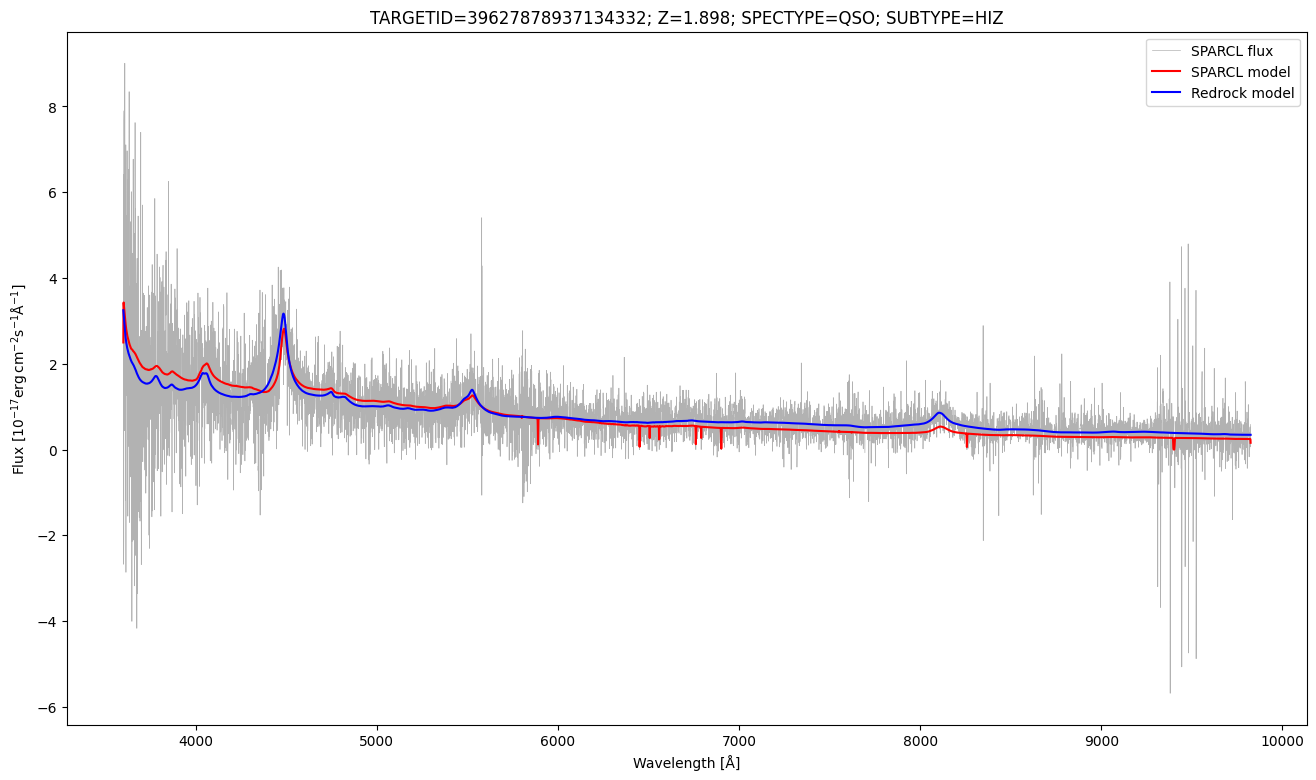

In [35]:
fig = plt.figure(figsize=(16, 9), dpi=100)
ax = fig.add_subplot(111)
spectrum_index = 12  # Step through spectra here.
pl0 = ax.plot(qso_wavelength, qso_flux[spectrum_index, :], 'k-', alpha=0.3, lw=0.5, label='SPARCL flux')
pl1 = ax.plot(qso_wavelength, qso_model_flux[spectrum_index, :], 'r-', label='SPARCL model')
pl2 = ax.plot(qso_wavelength, tmpl_model_flux[spectrum_index, :], 'b-', label='Redrock model')
txt = ax.set_xlabel('Wavelength [Å]')
txt = ax.set_ylabel(r'Flux [$10^{-17} \mathrm{erg} \, \mathrm{cm}^{-2} \mathrm{s}^{-1} \mathrm{\AA}^{-1}$]')
txt = ax.set_title(f"TARGETID={desi_qso_ids[spectrum_index]['targetid']:d}; Z={desi_qso_ids[spectrum_index]['z']:.3f}; SPECTYPE={desi_qso_ids[spectrum_index]['spectype']}; SUBTYPE={desi_qso_ids[spectrum_index]['subtype']}")
l = ax.legend()

<a class="anchor" id="sdss"></a>
## SDSS

### Find SDSS spectra

In [36]:
q = """
SELECT z.specobjid, z.bestobjid, z.z, z.zerr, z.zwarning, z.class, z.subclass,
       z.rchi2diff, z.primtarget, z.sectarget
FROM sdss_dr17.specobj AS z
WHERE z.bestobjid > 0
    AND z.run2d = '26'
    AND z.plate = 2955
    AND z.mjd = 54562
    AND z.class = 'GALAXY'
    AND z.zwarning = 0
ORDER BY z.specobjid
LIMIT 50
"""
sdss_ids = qc.query(sql=q, fmt='table')
sdss_ids

specobjid,bestobjid,z,zerr,zwarning,class,subclass,rchi2diff,primtarget,sectarget
int64,int64,float64,float64,int64,str6,str11,float64,int64,int64
3327035125891360768,1237655468065620461,0.26219922,6.426468e-05,0,GALAXY,--,0.16153336,96,0
3327036500280895488,1237655468065489538,0.21097003,5.7919853e-05,0,GALAXY,--,0.13921309,64,0
3327038424426244096,1237655468065620456,0.2605426,6.229882e-05,0,GALAXY,--,0.22558784,32,0
3327038974182057984,1237655468065620382,0.11276812,1.5994665e-05,0,GALAXY,--,0.510905,64,0
3327040073693685760,1237651736318574966,0.06364931,2.8312488e-05,0,GALAXY,--,0.42436635,64,0
3327040348571592704,1237651736318640378,0.20836118,4.189276e-05,0,GALAXY,--,1.1794078,96,0
3327040898327406592,1237655468602491146,0.20784536,4.1236628e-05,0,GALAXY,--,0.61972916,64,0
3327041722961127424,1237651736318575080,0.1408417,1.9260546e-05,0,GALAXY,STARFORMING,0.49670327,64,0
3327042822472755200,1237651736318574838,0.21259658,7.138862e-05,0,GALAXY,--,0.14038157,96,0


**QA**: Do we really have 50 unique spectra?

In [37]:
assert (np.unique(sdss_ids['specobjid']) == sdss_ids['specobjid']).all()

### Retrieve SDSS spectra

With the set of `specobjid` obtained above, we can directly retrieve SDSS spectra.

In [38]:
include = client.get_all_fields(dataset_list=['SDSS-DR17'])
sdss_spectra = client.retrieve_by_specid(specid_list=sdss_ids['specobjid'].value.tolist(),
                                         include=include,
                                         dataset_list=['SDSS-DR17'])
sdss_spectra.info

{'status': {'success': True,
  'info': ["Successfully found 50 records in dr_list=['SDSS-DR17']"],
  'warnings': []}}

**QA**: Did we really find all of the expected spectra? Note that we have to assume `specid == specobjid`.

Side effect: this also sorts the returned records to match the order of the inputs.

In [39]:
sdss_records = sorted(sdss_spectra.records, key=lambda x: x.specid)
assert (np.array([r.specid for r in sdss_records]) == sdss_ids['specobjid']).all()
assert all([r.plate == 2955 for r in sdss_records])
assert all([r.mjd == 54562 for r in sdss_records])

**QA**: Do all spectra records have the same wavelength solution?

In [40]:
assert all([(r.wavelength == sdss_records[0].wavelength).all() for r in sdss_records])

**QA**: Are any of the spectra fully masked?

In [41]:
sdss_fully_masked = np.zeros((len(sdss_records), ), dtype=bool)

for k in range(len(sdss_records)):
    assert np.isfinite(sdss_records[k].flux).all()
    assert np.isfinite(sdss_records[k].ivar).all()
    if (sdss_records[k].mask > 0).all():
        print(f"WARNING: Spectrum record {k:d} is fully masked!")
        sdss_fully_masked[k] = True

**Note** that one of the spectra has a non-zero mask for every pixel. This will cause problems with some versions of Prospect, so for the demonstration below, we will not attempt to plot that spectrum. Future versions of Prospect will handle this more gracefully.

#### View the contents of the first retrieved record

In [42]:
sdss_records[0]

{'redshift_err': 6.426467734854668e-05,
 'specprimary': True,
 'specid': 3327035125891360768,
 'wavemin': 3821.2021484375,
 'targetid': 1237655468065620461,
 'sparcl_id': 'f54e0331-5e22-11f0-95ba-525400f334e1',
 'instrument': 'SDSS',
 'spectype': 'GALAXY',
 'ra': 236.58816,
 'data_release': 'SDSS-DR17',
 'datasetgroup': 'SDSS_BOSS',
 'wavemax': 9191.7880859375,
 'telescope': 'sloan25m',
 'dec': 0.91476191,
 'redshift_warning': 0,
 'exptime': 3002.0,
 'site': 'apo',
 'redshift': 0.2621992230415344,
 'tcolumn': [0, 1, 2, 3, -1, -1, -1, -1, -1, -1],
 'spec2_g': 24.95490074157715,
 'run2d': 26,
 'elodie_feh': 0.0,
 'comments_person': '',
 'fracnsigma': [0.3508818745613098,
  0.0670764297246933,
  0.006413682363927364,
  0.0008017102954909205,
  0.0005344735691323876,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 'deredsn2': 0.0,
 'elodie_z': 0.0,
 'designid': -1,
 'platequality': 'good',
 'spectrosynflux_ivar': [2.1609764099121094,
  4.695135116577148,
  2.821389675140381,
  1.6888610124588013,
  0

### Organize metadata

Prospect needs several inputs:

1. An object containing spectra.  In this case we'll use a [`Spectrum1D`](https://specutils.readthedocs.io/en/stable/api/specutils.Spectrum1D.html#specutils.Spectrum1D) object.
   * The object contains the usual flux, wavelength, uncertainty.
   * In addtion a "plugmap" table is needed. This should be an Astropy `Table` with the expected columns.
2. A redshift catalog. This should be an Astropy `Table` with the expected columns.
3. A model spectrum.  The model is actually provided by SPARCL, but we need to input it separately.

#### Spectrum object

First we assemble the components of the spectrum object

In [43]:
flux = np.zeros((len(sdss_records), sdss_records[0].flux.shape[0]),
                dtype=sdss_records[0].flux.dtype)
uncertainty = np.zeros((len(sdss_records), sdss_records[0].ivar.shape[0]),
                       dtype=sdss_records[0].ivar.dtype)
mask = np.zeros((len(sdss_records), sdss_records[0].mask.shape[0]),
                dtype=sdss_records[0].mask.dtype)

meta = {'sparcl_id': list(), 'data_release': list()}
sparcl_id = list()
data_release = list()

for k in range(len(sdss_records)):
    flux[k, :] = sdss_records[k].flux
    uncertainty[k, :] = sdss_records[k].ivar
    mask[k, :] = sdss_records[k].mask
    meta['sparcl_id'].append(sdss_records[k].sparcl_id)
    meta['data_release'].append(sdss_records[k].data_release)

And the "plugmap" table. We'll start with photometric quantities.

In [44]:
columns = ('z.specobjid', 'p.objid', 'p.ra', 'p.dec', 'p.u', 'p.g', 'p.r', 'p.i', 'p.z')
q = """
SELECT {0}
FROM sdss_dr17.specobj AS z
JOIN sdss_dr17.photoplate AS p
ON z.bestobjid = p.objid
WHERE p.objid IN ({1})
ORDER BY z.specobjid
""".format(', '.join(columns), ', '.join([str(t) for t in sdss_ids['bestobjid'].value.tolist()]))

plugmap = qc.query(sql=q, fmt='table')

In [45]:
for col in plugmap.colnames:
    plugmap.rename_column(col, col.upper())
mag = np.zeros((len(plugmap), 5), dtype=plugmap['G'].value.dtype)
for k, band in enumerate('UGRIZ'):
    mag[:, k] = plugmap[band].value
plugmap.add_column(mag, name='MAG')
plugmap.add_column(sdss_ids['primtarget'], name='PRIMTARGET')
plugmap.add_column(sdss_ids['sectarget'], name='SECTARGET')
meta['plugmap'] = plugmap[~sdss_fully_masked]

**QA**: Did we find photometry for every `bestobjid`?

In [46]:
assert (plugmap['OBJID'] == sdss_ids['bestobjid']).all()

Finally assemble the object.

In [47]:
sdss_prospect = Spectrum1D(flux=flux[~sdss_fully_masked, :] * u.Unit('1e-17 erg / (Angstrom cm2 s)'),
                           spectral_axis=sdss_records[0].wavelength * u.Unit('Angstrom'),
                           uncertainty=InverseVariance(uncertainty[~sdss_fully_masked, :]),
                           mask=mask[~sdss_fully_masked, :] != 0,
                           meta=meta)

#### Redshift catalog

We can re-use the initial query above; it was deliberately constructed.

In [48]:
sdss_zcatalog = sdss_ids.copy()
for col in sdss_zcatalog.colnames:
    if col == 'zerr':
        sdss_zcatalog.rename_column(col, 'Z_ERR')
    else:
        sdss_zcatalog.rename_column(col, col.upper())
sdss_zcatalog

SPECOBJID,BESTOBJID,Z,Z_ERR,ZWARNING,CLASS,SUBCLASS,RCHI2DIFF,PRIMTARGET,SECTARGET
int64,int64,float64,float64,int64,str6,str11,float64,int64,int64
3327035125891360768,1237655468065620461,0.26219922,6.426468e-05,0,GALAXY,--,0.16153336,96,0
3327036500280895488,1237655468065489538,0.21097003,5.7919853e-05,0,GALAXY,--,0.13921309,64,0
3327038424426244096,1237655468065620456,0.2605426,6.229882e-05,0,GALAXY,--,0.22558784,32,0
3327038974182057984,1237655468065620382,0.11276812,1.5994665e-05,0,GALAXY,--,0.510905,64,0
3327040073693685760,1237651736318574966,0.06364931,2.8312488e-05,0,GALAXY,--,0.42436635,64,0
3327040348571592704,1237651736318640378,0.20836118,4.189276e-05,0,GALAXY,--,1.1794078,96,0
3327040898327406592,1237655468602491146,0.20784536,4.1236628e-05,0,GALAXY,--,0.61972916,64,0
3327041722961127424,1237651736318575080,0.1408417,1.9260546e-05,0,GALAXY,STARFORMING,0.49670327,64,0
3327042822472755200,1237651736318574838,0.21259658,7.138862e-05,0,GALAXY,--,0.14038157,96,0


#### Model spectra

Prospect expects a model in the form of a tuple containing wavelength and flux. Since SPARCL provides the model, this is easy.  There are other ways to specify the model, but these require more access to the SDSS *files*.

In [49]:
model_flux = np.zeros((len(sdss_records), sdss_records[0].model.shape[0]),
                      dtype=sdss_records[0].model.dtype)

for k in range(len(sdss_records)):
        model_flux[k, :] = sdss_records[k].model

sdss_model = (sdss_records[0].wavelength, model_flux[~sdss_fully_masked, :])

### Start prospect

With everything assembled, the interface to prospect is just a single call.

In [ ]:
plotspectra(sdss_prospect,
            zcatalog=sdss_zcatalog[~sdss_fully_masked],
            redrock_cat=None,
            notebook=True,
            with_thumb_tab=False,
            with_vi_widgets=False,
            with_coaddcam=False,
            mask_type='PRIMTARGET',
            model_from_zcat=False,
            model=sdss_model)

<a class="anchor" id="boss"></a>
## (e)BOSS

### Find (e)BOSS spectra

In [51]:
q = """
SELECT z.specobjid, z.bestobjid, z.z, z.zerr, z.zwarning, z.class, z.subclass,
       z.rchi2diff, z.boss_target1, z.eboss_target0, z.eboss_target1,
       z.eboss_target2
FROM sdss_dr17.specobj AS z
WHERE z.bestobjid > 0
    AND z.run2d = 'v5_13_2'
    AND z.plate = 9599
    AND z.mjd = 58131
    AND z.class = 'GALAXY'
    AND z.zwarning = 0
ORDER BY z.specobjid
LIMIT 50
"""
boss_ids = qc.query(sql=q, fmt='table')
boss_ids

specobjid,bestobjid,z,zerr,zwarning,class,subclass,rchi2diff,boss_target1,eboss_target0,eboss_target1,eboss_target2
int64,int64,float64,float64,int64,str6,int64,float64,int64,int64,int64,int64
-7639230456632420352,1237665127987282622,0.8864001,7.46243e-05,0,GALAXY,--,0.06786668,0,0,17592186044416,562949953421312
-7639227982731257856,1237665098459972441,0.9110273,0.00010862139,0,GALAXY,--,0.017336488,0,0,17592186044416,562949953421312
-7639227707853350912,1237665128524284395,0.38422197,3.6719743e-05,0,GALAXY,--,0.04284048,0,0,17592186044416,562949953421312
-7639227432975443968,1237665098459972179,0.800372,7.3419695e-05,0,GALAXY,--,0.026912212,0,0,17592186044416,562949953421312
-7639226333463816192,1237665128524350020,0.7552478,0.00021523784,0,GALAXY,--,0.013269424,0,0,17592186044416,562949953421312
-7639225783708002304,1237665128524415517,0.8210997,8.6923865e-05,0,GALAXY,--,0.023777902,0,0,17592186044416,562949953421312
-7639225233952188416,1237665098460037767,1.4448175,0.7513441,0,GALAXY,--,0.011829615,0,0,17592186044416,562949953421312
-7639224959074281472,1237665128524153288,0.92107,0.000118537646,0,GALAXY,--,0.017925024,0,0,17592186044416,562949953421312
-7639224409318467584,1237665097923035567,0.98253536,0.00013488902,0,GALAXY,--,0.0124723315,0,0,17592186044416,562949953421312


**QA**: Do we really have 50 unique spectra?

In [52]:
assert (np.unique(boss_ids['specobjid']) == boss_ids['specobjid']).all()

### Retrieve (e)BOSS spectra

With the set of `specobjid` obtained above, we can directly retrieve (e)BOSS spectra.

In [53]:
include = client.get_all_fields(dataset_list=['BOSS-DR17'])
boss_spectra = client.retrieve_by_specid(specid_list=boss_ids['specobjid'].value.tolist(),
                                         include=include,
                                         dataset_list=['BOSS-DR17'])
boss_spectra.info

{'status': {'success': True,
  'info': ["Successfully found 50 records in dr_list=['BOSS-DR17']"],
  'warnings': []}}

**QA**: Did we really find all of the expected spectra?

Side effect: this also sorts the returned records to match the order of the inputs.

In [54]:
boss_records = sorted(boss_spectra.records, key=lambda x: x.specid)
assert (np.array([r.specid for r in boss_records]) == boss_ids['specobjid']).all()
assert all([r.plate == 9599 for r in boss_records])
assert all([r.mjd == 58131 for r in boss_records])

**QA**: Do all spectra records have the same wavelength solution?

In [55]:
assert all([(r.wavelength == boss_records[0].wavelength).all() for r in boss_records])

**QA**: Are any of the spectra fully masked?

In [56]:
boss_fully_masked = np.zeros((len(boss_records), ), dtype=bool)

for k in range(len(boss_records)):
    assert np.isfinite(boss_records[k].flux).all()
    assert np.isfinite(boss_records[k].ivar).all()
    if (boss_records[k].mask > 0).all():
        print(f"WARNING: Spectrum record {k:d} is fully masked!")
        boss_fully_masked[k] = True

#### View the contents of the first retrieved record

In [57]:
boss_records[0]

{'redshift_err': 7.462430221494287e-05,
 'specprimary': True,
 'specid': -7639230456632420352,
 'wavemin': 3601.637451171875,
 'targetid': 1237665127987282622,
 'sparcl_id': '098d97da-252f-11f0-bc98-525400f334e1',
 'instrument': 'BOSS',
 'spectype': 'GALAXY',
 'ra': 134.30633999999998,
 'data_release': 'BOSS-DR17',
 'datasetgroup': 'SDSS_BOSS',
 'wavemax': 10332.37109375,
 'telescope': 'sloan25m',
 'dec': 23.560574,
 'redshift_warning': 0,
 'exptime': 3600.35,
 'site': 'apo',
 'redshift': 0.8864001035690308,
 'tcolumn': [0, 1, 2, 3, -1, -1, -1, -1, -1, -1],
 'spec2_g': 6.294640064239502,
 'run2d': 'v5_13_2',
 'elodie_feh': 0.0,
 'comments_person': '',
 'fracnsigma': [0.3162296712398529,
  0.055831827223300934,
  0.009041591547429562,
  0.0011301989434286952,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 'deredsn2': 5.500629901885986,
 'elodie_z': 0.0,
 'designid': 10182,
 'platequality': 'good',
 'spectrosynflux_ivar': [6.276416778564453,
  9.02142333984375,
  6.571553707122803,
  3.8821

### Organize metadata

Prospect needs several inputs:

1. An object containing spectra.  In this case we'll use a [`Spectrum1D`](https://specutils.readthedocs.io/en/stable/api/specutils.Spectrum1D.html#specutils.Spectrum1D) object.
   * The object contains the usual flux, wavelength, uncertainty.
   * In addtion a "plugmap" table is needed. This should be an Astropy `Table` with the expected columns.
2. A redshift catalog. This should be an Astropy `Table` with the expected columns.
3. A model spectrum.  The model is actually provided by SPARCL, but we need to input it separately.

#### Spectrum object

First we assemble the components of the spectrum object

In [58]:
flux = np.zeros((len(boss_records), boss_records[0].flux.shape[0]),
                dtype=boss_records[0].flux.dtype)
uncertainty = np.zeros((len(boss_records), boss_records[0].ivar.shape[0]),
                       dtype=boss_records[0].ivar.dtype)
mask = np.zeros((len(boss_records), boss_records[0].mask.shape[0]),
                dtype=boss_records[0].mask.dtype)

meta = {'sparcl_id': list(), 'data_release': list()}
sparcl_id = list()
data_release = list()

for k in range(len(boss_records)):
    flux[k, :] = boss_records[k].flux
    uncertainty[k, :] = boss_records[k].ivar
    mask[k, :] = boss_records[k].mask
    meta['sparcl_id'].append(boss_records[k].sparcl_id)
    meta['data_release'].append(boss_records[k].data_release)

And the "plugmap" table. We'll start with photometric quantities.

In [59]:
columns = ('z.specobjid', 'p.objid', 'p.ra', 'p.dec', 'p.u', 'p.g', 'p.r', 'p.i', 'p.z')
q = """
SELECT {0}
FROM sdss_dr17.specobj AS z
JOIN sdss_dr17.photoplate AS p
ON z.bestobjid = p.objid
WHERE p.objid IN ({1})
ORDER BY z.specobjid
""".format(', '.join(columns), ', '.join([str(t) for t in boss_ids['bestobjid'].value.tolist()]))

plugmap = qc.query(sql=q, fmt='table')

In [60]:
for col in plugmap.colnames:
    plugmap.rename_column(col, col.upper())
mag = np.zeros((len(plugmap), 5), dtype=plugmap['G'].value.dtype)
for k, band in enumerate('UGRIZ'):
    mag[:, k] = plugmap[band].value
plugmap.add_column(mag, name='MAG')
plugmap.add_column(boss_ids['boss_target1'], name='BOSS_TARGET1')
plugmap.add_column(boss_ids['eboss_target0'], name='EBOSS_TARGET0')
plugmap.add_column(boss_ids['eboss_target1'], name='EBOSS_TARGET1')
plugmap.add_column(boss_ids['eboss_target2'], name='EBOSS_TARGET2')
meta['plugmap'] = plugmap[~boss_fully_masked]

**QA**: Did we find photometry for every `bestobjid`?

In [61]:
assert (plugmap['OBJID'] == boss_ids['bestobjid']).all()

Finally assemble the object.

In [62]:
boss_prospect = Spectrum1D(flux=flux[~boss_fully_masked, :] * u.Unit('1e-17 erg / (Angstrom cm2 s)'),
                           spectral_axis=boss_records[0].wavelength * u.Unit('Angstrom'),
                           uncertainty=InverseVariance(uncertainty[~boss_fully_masked, :]),
                           mask=mask[~boss_fully_masked, :] != 0,
                           meta=meta)

#### Redshift catalog

We can re-use the initial query above; it was deliberately constructed.

In [63]:
boss_zcatalog = boss_ids.copy()
for col in boss_zcatalog.colnames:
    if col == 'zerr':
        boss_zcatalog.rename_column(col, 'Z_ERR')
    else:
        boss_zcatalog.rename_column(col, col.upper())
boss_zcatalog

SPECOBJID,BESTOBJID,Z,Z_ERR,ZWARNING,CLASS,SUBCLASS,RCHI2DIFF,BOSS_TARGET1,EBOSS_TARGET0,EBOSS_TARGET1,EBOSS_TARGET2
int64,int64,float64,float64,int64,str6,int64,float64,int64,int64,int64,int64
-7639230456632420352,1237665127987282622,0.8864001,7.46243e-05,0,GALAXY,--,0.06786668,0,0,17592186044416,562949953421312
-7639227982731257856,1237665098459972441,0.9110273,0.00010862139,0,GALAXY,--,0.017336488,0,0,17592186044416,562949953421312
-7639227707853350912,1237665128524284395,0.38422197,3.6719743e-05,0,GALAXY,--,0.04284048,0,0,17592186044416,562949953421312
-7639227432975443968,1237665098459972179,0.800372,7.3419695e-05,0,GALAXY,--,0.026912212,0,0,17592186044416,562949953421312
-7639226333463816192,1237665128524350020,0.7552478,0.00021523784,0,GALAXY,--,0.013269424,0,0,17592186044416,562949953421312
-7639225783708002304,1237665128524415517,0.8210997,8.6923865e-05,0,GALAXY,--,0.023777902,0,0,17592186044416,562949953421312
-7639225233952188416,1237665098460037767,1.4448175,0.7513441,0,GALAXY,--,0.011829615,0,0,17592186044416,562949953421312
-7639224959074281472,1237665128524153288,0.92107,0.000118537646,0,GALAXY,--,0.017925024,0,0,17592186044416,562949953421312
-7639224409318467584,1237665097923035567,0.98253536,0.00013488902,0,GALAXY,--,0.0124723315,0,0,17592186044416,562949953421312


#### Model spectra

Prospect expects a model in the form of a tuple containing wavelength and flux. Since SPARCL provides the model, this is easy.  There are other ways to specify the model, but these require more access to the (e)BOSS *files*.

In [64]:
model_flux = np.zeros((len(boss_records), boss_records[0].model.shape[0]),
                      dtype=boss_records[0].model.dtype)

for k in range(len(boss_records)):
        model_flux[k, :] = boss_records[k].model

boss_model = (boss_records[0].wavelength, model_flux[~boss_fully_masked, :])

### Start prospect

With everything assembled, the interface to prospect is just a single call.

In [ ]:
plotspectra(boss_prospect,
            zcatalog=boss_zcatalog[~boss_fully_masked],
            redrock_cat=None,
            notebook=True,
            with_thumb_tab=False,
            with_vi_widgets=False,
            with_coaddcam=False,
            mask_type='EBOSS_TARGET1',
            model_from_zcat=False,
            model=boss_model)